In [1]:
%reset -f 
%load_ext autoreload
%autoreload 2
%matplotlib notebook




from copy import deepcopy
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from pylab import *

rc('axes', linewidth=1)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)

from scipy.stats import pearsonr,kendalltau,spearmanr



In [2]:
from scipy.signal import argrelextrema
import numpy as np
from scipy import signal
from scipy import interpolate


class mXANES:
    
    def __init__(self, evsmu=None, srange=None, sstruct=None, ca=None, E0=None, 
                 xanesid=None, source=None, vcn=None, edge=None): 

        if evsmu is None:
            self.X0 = np.array([])
            self.Y0 = np.array([])
        else:
            self.X0 = np.array(evsmu[0])
            self.Y0 = np.array(evsmu[1])

        if srange:
            sel = (self.X0 >= srange[0]) & (self.X0 <= srange[1])
            self.X0 = self.X0[sel]
            self.Y0 = self.Y0[sel]            

        # Energy offset
        if E0 is None:
            self.E0 = self.X0[0]
        else:
            self.E0 = E0
            
        # XANES id
        if xanesid is None:
            self.xanesid = 'not_set'
        else:
            self.xanesid = xanesid 
            
        # XANES edge
        if edge is None:
            self.edge = 'not_set'
        else:
            self.edge = edge 
            
        # central atom
        if ca is None:
            self.ca = 'not_set'
        else:
            self.ca = ca             
            
        # source
        if source is None:
            self.source = 'not_set'
        else:
            self.source = source            
            
        # symmetrized structure
        if sstruct is None:
            self.sstruct = [[],[]]
        else:
            self.sstruct = sstruct   
            
        # vcn holder
        if vcn is None:
            self.vcn = [[],[]]
        else:
            self.vcn = vcn  
                        
        self.peaks = []
        
            
                                
    def Interpolate(self,iterprange,stepsize=0.1):
              
        if self.X[0] > iterprange[0]:
            # left padding
            npts = int((self.X[0]-iterprange[0])/stepsize)+1
            x_patch = np.linspace(iterprange[0],self.X[0]-stepsize,npts)
            y_patch=np.empty(len(x_patch)); y_patch.fill(self.Y[0])
            self.X = np.concatenate((x_patch,self.X.T), axis=0)
            self.Y = np.concatenate((y_patch,self.Y.T), axis=0)
            
            
        if self.X[-1] < iterprange[1]:
            # right padding            
            npts = int((iterprange[1]-self.X[-1])/stepsize)+2
            x_patch = np.linspace(self.X[-1],iterprange[1],npts)
            y_patch=np.empty(len(x_patch)); y_patch.fill(self.Y[-1])
            self.X = np.concatenate((self.X.T,x_patch), axis=0)
            self.Y = np.concatenate((self.Y.T,y_patch), axis=0)   

          
        f = interpolate.interp1d(self.X,self.Y,kind='linear')
        self.X = np.linspace(iterprange[0],iterprange[1], int((iterprange[1]-iterprange[0])/stepsize)+1  )
        self.Y = f(self.X) 
        
        
        

    def FindPeaks(self,xin=None,yin=None,srangep=None):
        
        if (xin is None) or (yin is None):
            xsearch = self.X0
            ysearch = self.Y0
        else:
            xsearch = xin
            ysearch = yin
                        
        if srangep:
            sel = (xsearch >= srangep[0]) & (xsearch <= srangep[1])
            xsearch = xsearch[sel]; ysearch = ysearch[sel]
        
        ipeaks = argrelextrema(ysearch, np.greater)[0] 
        
        peaks = []
        for i in ipeaks:
            peaks.append([xsearch[i],ysearch[i]])
        self.peaks = peaks 
        
        return peaks
 
 
    def yscale_by(self,yscale):
        self.Y = self.Y*yscale
 
 
 
    def transform(self,srange=None,irange=None,e0shift=False,
                  y0shift=True,normalize='max',xshift=None):
        
        self.X = self.X0.copy()
        self.Y = self.Y0.copy()
        
        if e0shift:
            self.X = self.X -self.E0         
               
        if xshift:
            self.X = self.X + xshift            

        if irange:
            self.Interpolate(irange)
                  
        if y0shift:
            self.Y = self.Y -self.Y[0]  

        if normalize == 'max':            
            self.Y = self.Y/max(self.Y)
        elif normalize == 'tail':
            self.Y = self.Y/self.Y[-1]
        elif normalize == 'none':
            self.Y = self.Y         
        else:
            self.Y = self.Y/max(self.Y)


    def get_vcn(self,vcncutoff=3):
        
        if self.sstruct and self.ca:
            try:
                nnfinder = VoronoiNN(cutoff=vcncutoff,allow_pathological=True)
                vcn = nnfinder.get_cn(self.sstruct, indices[i], use_weights=True)
                self.vcn = vcn
            except:
                nnfinder = VoronoiNN(cutoff=vcncutoff*2,allow_pathological=True)                
                vcn = nnfinder.get_cn(self.sstruct[0], self.sstruct[1], use_weights=True) 
                self.vcn = vcn
        
        return self.vcn


In [3]:
# load data
R_nslsii0  = np.loadtxt('./data/rutile/NSLS-II_2017.dat', unpack=True, comments='#', usecols=(0,1))
R_nslsi_0  = np.loadtxt('./data/rutile/NSLS-I_1994.dat', unpack=True, comments='#', usecols=(0,1))
R_diamon0  = np.loadtxt('./data/rutile/DIAMOND-2016.dat', unpack=True, comments='#', usecols=(0,1))

R_nslsii1 = mXANES(evsmu=R_nslsii0)
R_nslsi_1 = mXANES(evsmu=R_nslsi_0)
R_diamon1 = mXANES(evsmu=R_diamon0)

<IPython.core.display.Javascript object>


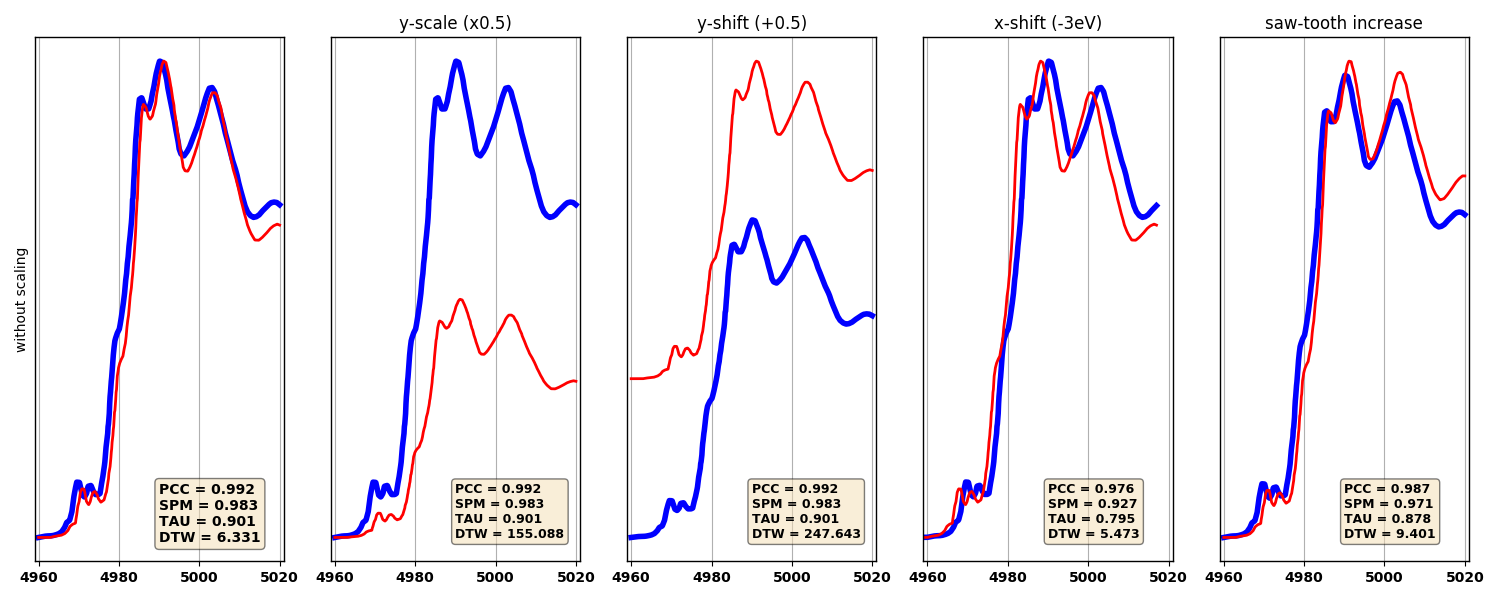

In [10]:

S1 = mXANES(evsmu=R_nslsi_0)
S2 = mXANES(evsmu=R_diamon0)




fig = plt.figure(figsize=(15,6)); 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax = fig.add_subplot('151'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.set_ylabel('without scaling')


ax = fig.add_subplot('152'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y*0.5
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('y-scale (x0.5)')


ax = fig.add_subplot('153'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y+0.5
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('y-shift (+0.5)')


ax = fig.add_subplot('154'); ax.grid(True)
S1.transform(irange=[4957,5017])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('x-shift (-3eV)')


ax = fig.add_subplot('155'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y
s = 0
for i in range(220,len(Y2)):
    Y2[i] = Y2[i] + s
    s = s + 0.2/len(Y2)
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('saw-tooth increase')


plt.tight_layout()
plt.savefig("plot1.png", transparent=True, dpi=300); #plt.close('all')

<IPython.core.display.Javascript object>


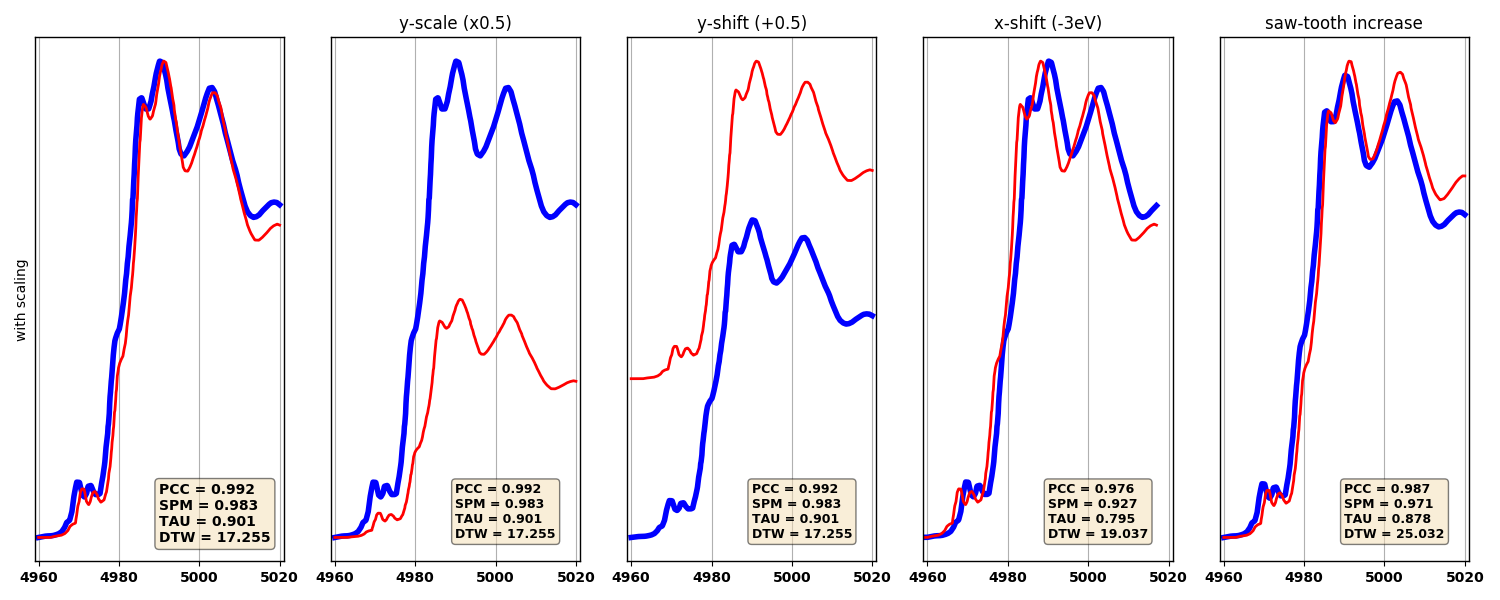

In [11]:

S1 = mXANES(evsmu=R_nslsi_0)
S2 = mXANES(evsmu=R_diamon0)




fig = plt.figure(figsize=(15,6)); 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax = fig.add_subplot('151'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
Y2 = (Y2 - np.mean(Y2))/np.std(Y2)
Y1 = (Y1 - np.mean(Y1))/np.std(Y1)
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax.set_ylabel('with scaling')


ax = fig.add_subplot('152'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y*0.5
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
Y2 = (Y2 - np.mean(Y2))/np.std(Y2)
Y1 = (Y1 - np.mean(Y1))/np.std(Y1)
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('y-scale (x0.5)')


ax = fig.add_subplot('153'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y+0.5
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
Y2 = (Y2 - np.mean(Y2))/np.std(Y2)
Y1 = (Y1 - np.mean(Y1))/np.std(Y1)
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('y-shift (+0.5)')


ax = fig.add_subplot('154'); ax.grid(True)
S1.transform(irange=[4957,5017])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
Y2 = (Y2 - np.mean(Y2))/np.std(Y2)
Y1 = (Y1 - np.mean(Y1))/np.std(Y1)
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('x-shift (-3eV)')


ax = fig.add_subplot('155'); ax.grid(True)
S1.transform(irange=[4960,5020])
S2.transform(irange=[4960,5020])
E = S1.X
Y1 = S1.Y
Y2 = S2.Y
s = 0
for i in range(220,len(Y2)):
    Y2[i] = Y2[i] + s
    s = s + 0.2/len(Y2)
ax.plot(E,Y1,'-b', lw=4)
ax.plot(E,Y2,'-r',lw=2)
ax.set_xlim([4959,5021])
ax.set_yticks([])
Y2 = (Y2 - np.mean(Y2))/np.std(Y2)
Y1 = (Y1 - np.mean(Y1))/np.std(Y1)
pcc = 'PCC = {:5.3f}'.format(pearsonr(Y1,Y2)[0])
spm = 'SPM = {:5.3f}'.format(spearmanr(Y1,Y2)[0]) 
tau = 'TAU = {:5.3f}'.format(kendalltau(Y1,Y2)[0])
dtw = 'DTW = {:5.3f}'.format(fastdtw(Y1,Y2, dist=euclidean)[0])
ax.text(0.5, 0.15, pcc+'\n'+spm+'\n'+tau+'\n'+dtw, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
ax.set_title('saw-tooth increase')


plt.tight_layout()
plt.savefig("plot2.png", transparent=True, dpi=300); #plt.close('all')